In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import SAC_class_setting
import PPO_class_setting
import util
import replay_buffer as rb

In [2]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
action_space = env.action_space

# ppo(dont use)

In [3]:
actor_lr = 3e-4
critic_lr = 3e-4
hidden_layer_num = 3
num_episodes = 2000
hidden_dim = 1024
gamma = 0.99
lmbda = 0.98
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [4]:
epi_list_PPO = np.empty((5, num_episodes))
for i in range(5):
    PPO_agent = PPO_class_setting.PPOContinuous(state_dim, hidden_dim, action_dim, hidden_layer_num, actor_lr, critic_lr, gamma, lmbda, epochs, eps, device)
    return_list = util.train_on_policy_agent(env, PPO_agent, num_episodes)
    epi_list_PPO[i, :] = return_list

Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]/home/nomushroom/vsc/SAC_imitationlearning/PPO_class_setting.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1686122008392/work/torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 0:  54%|█████▍    | 108/200 [00:25<00:21,  4.26it/s, episode=100, return=-1324.818]


KeyboardInterrupt: 

# SAC

In [3]:
actor_lr = 3e-4
critric_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005
buffer_size = 100000
minimal_size = 1000
batch_size = 64
hidden_layer_num = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_entropy = -torch.prod(torch.tensor(env.action_space.shape).to(device))

In [4]:
epi_list = np.empty((5, num_episodes))
for i in range(5):
    p_replay_buffer = rb.ReplayBuffer(state_dim, action_dim, buffer_size, device)
    pendulum_agent = SAC_class_setting.SACContinuous(p_replay_buffer, state_dim, hidden_dim, action_dim, hidden_layer_num, action_space,
                                    actor_lr, critric_lr, alpha_lr, tau, gamma, device)

    return_list = util.train_off_policy_agent(env, pendulum_agent, num_episodes, minimal_size, batch_size)
    epi_list[i, :] = return_list

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]

/home/nomushroom/vsc/SAC_imitationlearning/SAC_class_setting.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1686122008392/work/torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it, episode=100, return=-156.007]


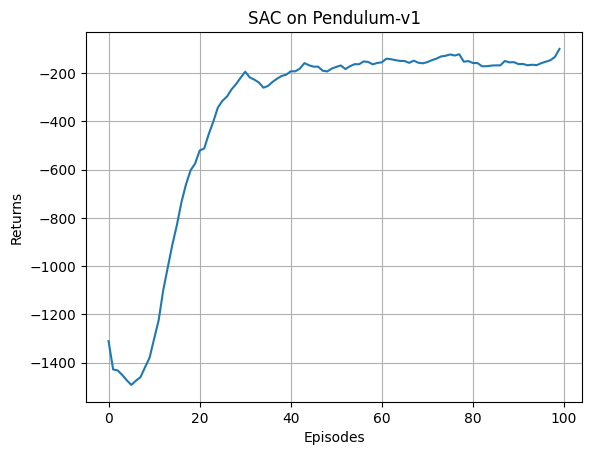

In [11]:
mean_list = np.mean(epi_list, axis=0)
smooth_return = util.smooth_figure(mean_list, 9)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, smooth_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.grid()
plt.show()

In [ ]:
np.save('SAC_1.npy', epi_list)

# prioritized experience replay SAC

In [8]:
epi_list_per = np.empty((5, num_episodes))
for i in range(5):
    per_replay_buffer = rb.PrioritizedReplayBuffer(state_dim, action_dim, buffer_size, device)
    pendulum_agent = SAC_class_setting.SACContinuous(per_replay_buffer, state_dim, hidden_dim, action_dim, hidden_layer_num, action_space,
                                    actor_lr, critric_lr, alpha_lr, tau, gamma, device)

    return_list = util.train_off_policy_agent(env, pendulum_agent, num_episodes, minimal_size, batch_size)
    epi_list[i, :] = return_list

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it, episode=100, return=-208.002]


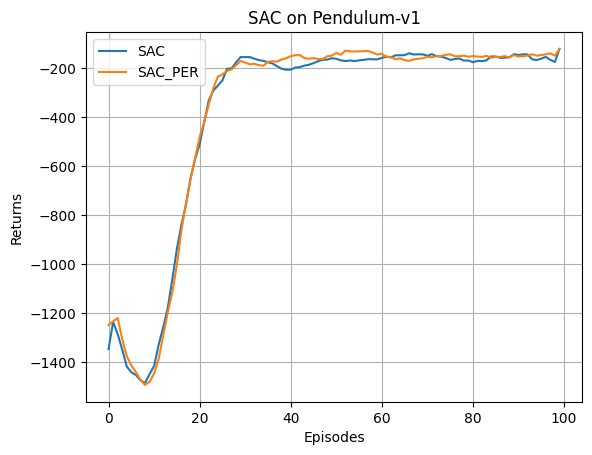

In [15]:
mean_per = epi_list_per.mean(axis=0)
smooth_return_per = util.smooth_figure(mean_per, 9)
episodes_list = list(range(len(mean_list)))
plt.plot(episodes_list, smooth_return)
plt.plot(episodes_list, smooth_return_per)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.legend(['SAC', 'SAC_PER'])
plt.title('SAC on {}'.format(env_name))
plt.grid()
plt.show()

In [ ]:
np.save('SAC_PER_1.npy', epi_list_per)

# SAC-GAIL